In [61]:
#!pip install cdlib
!pip uninstall cdlib

Found existing installation: cdlib 0.1.8
Uninstalling cdlib-0.1.8:
  Would remove:
    /Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/cdlib-0.1.8.dist-info/*
    /Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/cdlib/*
Proceed (y/n)? ^C
ERROR: Operation cancelled by user


In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import scipy.special

import torch

np.seterr(all='raise')
scipy.special.seterr(all='raise')

#import cdlib

{'singular': 'ignore',
 'underflow': 'ignore',
 'overflow': 'ignore',
 'slow': 'ignore',
 'loss': 'ignore',
 'no_result': 'ignore',
 'domain': 'ignore',
 'arg': 'ignore',
 'other': 'ignore'}

In [3]:
#from cdlib import algorithms
import networkx as nx

In [4]:
import pickle
adjacency_list = []
with open('adjacency_list.data', 'rb') as filehandle:
    adjacency_list = pickle.load(filehandle)

In [5]:
g = nx.Graph()
for i in range(len(adjacency_list)):
    g.add_node(i)

for a in range(len(adjacency_list)):
    for b in adjacency_list[a]:
        if g.has_edge(a,b):
            continue
        g.add_edge(a,b)

/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


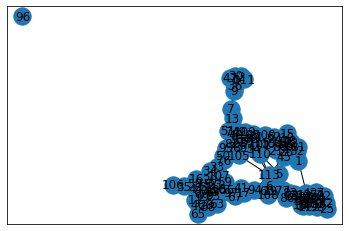

In [6]:
nx.draw_networkx(g)

In [7]:
"""
Name :: UnityId
Shruti Kuber :: skuber
Abhishek Lingwal :: aslingwa
Raunaq Saxena :: rsaxena
Chen, Jie, and Yousef Saad.
"Dense subgraph extraction with application to algorithms detection."
IEEE Transactions on Knowledge and Data Engineering 24.7 (2012): 1216-1230.
Reference internal: https://github.com/imabhishekl/CSC591_Community_Detection
"""

class __Node:

    def __init__(self, name):
        self.name = name
        self.left = None
        self.right = None
        self.parent = None
        self.num_edges = 0
        self.vertices = set()
        self.density = 0


class __Tree:

    def __init__(self):
        self.root = None

    def findLCA_Node(self, src_node, dest_node):
        while src_node is not None:
            if dest_node.name in src_node.vertices:
                return src_node
            src_node = src_node.parent
        return None

    def count_vertices_and_edges(self, edges_list, nodes_list):
        for edge in edges_list:
            lca_node = None

            src_node = nodes_list[edge[0]] if nodes_list.__contains__(edge[0]) else None
            dst_node = nodes_list[edge[1]] if nodes_list.__contains__(edge[1]) else None
            if src_node is not None and dst_node is not None:
                lca_node = self.findLCA_Node(src_node, dst_node)

            if lca_node is not None:
                lca_node.num_edges = lca_node.num_edges + 1

    def count_vertices_and_edges_wrap(self, root):
        if root.left is not None and root.right is not None:
            self.count_vertices_and_edges_wrap(root.left)
            self.count_vertices_and_edges_wrap(root.right)
        if root.left is not None and root.right is not None:
            root.num_edges = root.left.num_edges + root.right.num_edges + root.num_edges
        # print root.name, root.num_edges

    def compute_density(self, root):
        if root.left is None and root.right is None:
            return
        total_vertices = float(len(root.vertices))
        max_vertices = total_vertices * (total_vertices - 1) / 2
        root.density = root.num_edges / max_vertices
        self.compute_density(root.left)
        self.compute_density(root.right)

    def extract_sub_graph(self, root, min_density, result):

        if root is None:
            return
        if root.density > min_density:
            com = []
            for elem in list(root.vertices):
                com.append(elem)
            result.append(com)
        else:
            self.extract_sub_graph(root.left, min_density, result)
            self.extract_sub_graph(root.right, min_density, result)


def __make_set(r):
    r.parent = None
    r.vertices.add(r.name)


def __set_find(r):
    while r.parent != None:
        r = r.parent
    return r


# Building a new Node as Union of two sets
def __set_union(x, y):
    r = __Node("P" + str(x.name) + str(y.name))
    r.left = x
    r.right = y
    x.parent = r
    y.parent = r
    r.vertices = r.vertices.union(x.vertices, y.vertices)
    return r

In [10]:
def GDMP2(graph, min_threshold=.75):

    scipy.special.seterr(all='raise')
    A = nx.adjacency_matrix(graph)
    adj_matrix = A.todense()

    M = np.zeros(adj_matrix.shape)

    row, col = adj_matrix.shape

    # Building similarity function matrix, ie, Cosine Function matrix of all Column Vectors

    for x in range(0, row):
        #if x == 25 or x == 26:
            #print(adj_matrix[:, x])
        for y in range(x, col):
            try:
                M[x][y] = (1 - scipy.spatial.distance.cosine(adj_matrix[:, x], adj_matrix[:, y]))
            except:
                print ("FAILED ON", x, y)

    tuples = []
    # On basis of zero graph
    min_value = 1 if min(graph.nodes()) > 0 else 0

    # Considering only non zero values
    for (x, y), value in np.ndenumerate(M):
        if value != 0 and x != y:
            tuples.append(((x + min_value, y + min_value), value))

    C = sorted(tuples, key=lambda x: x[1])
    t = np.count_nonzero(adj_matrix)
    C = C[-t:]
    ln = len(C)
    ln = ln - 1

    nodes = dict()
    root_nodes = set()
    tree = __Tree()

    for index in range(ln, -1, -1):
        vertices, value = C[index]
        i, j = vertices
        if nodes.__contains__(i) is False:
            a = __Node(i)
            __make_set(a)
            nodes[i] = a
        if nodes.__contains__(j) is False:
            a = __Node(j)
            __make_set(a)
            nodes[j] = a

        i = nodes[i]
        j = nodes[j]
        ri = __set_find(i)
        rj = __set_find(j)
        if ri.vertices != rj.vertices:
            temp_root = __set_union(ri, rj)
            root_nodes.add(temp_root)

    root_nodes = filter(lambda entry: entry.parent is None, list(root_nodes))

    for temp_roots in root_nodes:
        tree.root = temp_roots

        # Counting number of vertices and Edges
        tree.count_vertices_and_edges(graph.edges(), nodes)

        # Summing up number of edges of children to parent
        tree.count_vertices_and_edges_wrap(tree.root)

        # Computing density of Tree Nodes
        tree.compute_density(tree.root)

        # Filtering Nodes as Per Density Threshold
        communities = []
        tree.extract_sub_graph(tree.root, min_threshold, communities)
        return communities

In [8]:
if nx.is_connected(g) != True:
    components_g = nx.connected_components(g)

gc = []
i = 0
for component in components_g:
    temp_graph = nx.Graph()
    
    temp_graph.add_nodes_from(component)
    for a in range(len(adjacency_list)):
        for b in adjacency_list[a]:
            if temp_graph.has_edge(a,b):
                continue
            if temp_graph.has_node(a) and temp_graph.has_node(b):
                temp_graph.add_edge(a,b)
    gc.append(temp_graph)
    #print(component)
    i += 1

networkx.classes.graph.Graph

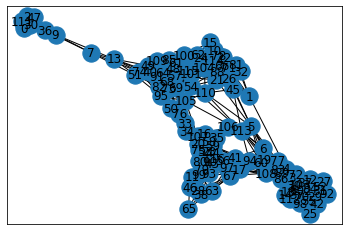

In [9]:
nx.draw_networkx(gc[0])
type(gc[0])

In [12]:
blocked = GDMP2(gc[0], min_threshold = .5)

In [11]:
A = nx.adjacency_matrix(g)
adj_matrix = A.todense()

scipy.spatial.distance.cosine()

NameError: name 'graph' is not defined

In [13]:
blocked

[[33, 34],
 [96, 98, 75, 43, 44, 79, 80, 17, 115, 20, 53, 23, 56, 90, 93],
 [19, 107, 60, 77, 94],
 [50, 76],
 [46, 28, 38, 63],
 [52, 27, 12, 92, 31],
 [72, 3],
 [97, 4, 37, 70, 101, 39, 8, 102, 42, 14, 111, 18, 84, 55, 87, 29],
 [89, 83, 86],
 [64,
  68,
  69,
  73,
  74,
  82,
  85,
  91,
  95,
  100,
  40,
  104,
  108,
  48,
  49,
  114,
  51,
  54,
  57,
  61],
 [1, 66, 71, 10, 78, 15, 81, 21, 22, 24, 88, 26, 32, 103, 45, 113, 62],
 [0, 2, 36, 9, 110, 30, 47]]